# Independent and chain pixel models for Skin Detection : Model, inference and learning


# Goals : 
1. A presentation of the language of probability 
1. A presentation of the Naive Bayes Classifier
1. A presentation of Hidden Markov Model (HMM)
2. Formal definitions on inference and learning with HMM
3. An application to Skin Detection

# Author: Romain Raveaux (romain.raveaux@univ-tours.fr)

# The lecture
The content of the is notebook is based on the following lectures: 
Supervised Machine Learning for structured input/output: 

*   1\. **Introduction to supervised Machine Learning: A probabilistic introduction [PDF](http://romain.raveaux.free.fr/document/courssupervisedmachinelearningRaveaux.pdf)

*   2\. **Connecting local models : The case of chains** [PDF slides](http://romain.raveaux.free.fr/document/Connecting%20local%20models%20the%20case%20of%20chains%20.pdf)

*   3\. Connecting local models : Beyond chains and trees.[PDF slides](http://romain.raveaux.free.fr/document/Structured%20Output%20Learning.pdf)

*   4\. Machine Learning and Graphs : Introduction and problems [PDF slides](http://romain.raveaux.free.fr/document/cours%20IA%20DI5%20graphs%20introV2.pdf)

*   5\. Graph Neural Networks. [PDF slides](http://romain.raveaux.free.fr/document/graph%20neural%20networks%20romain%20raveaux.pdf)

*   6\. Graph Kernels. [PDF slides](http://romain.raveaux.free.fr/document/graph%20kernel%20romain%20raveaux.pdf)


# Language of probability
1. Random variables
1. Type of probability distribution : The case of a categorical distribution
1. Pr(X,Y) = joint probability 
1. Pr(Y|X) = conditional probability
1. Pr(X) = Marginal probability

## We start with the imports, they are quite basic:
 Numpy to perform the array computation and 
 Matplotlib to display plots
 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as Image

%matplotlib inline  


# Random Variables
Probability deals with random variables. A variable whose values depend on the result of an experiment subject to a random phenomenon. Let's create a dice and a coin. The value taken by the dice is a random variable. The value taken by the coin is a random variable.

$\mathcal{D}= \{x^{(j)},y^{(j)}\}_{j=1}^N$ with $N$ the number of pair samples.

$x^{(j)} \in \mathcal{S}$ is a value taken by the dice. $\textbf{Or x for short when the index does not matter}$.

Let us define $D=|\mathcal{S}|$. $D$ is the size of the set of all possible dice values. The number of possible dice values \{1,2,3,4,5,6\} or {0,1,2,3,4,5\}.


$y^{(j)} \in \mathcal{E}$ is a coin value. $\textbf{Or y for short when the index does not matter}$.

$\mathcal{E}$ is the set of all possible coin values \{0,1\}. 

Let us define $K=|\mathcal{E}|$. $K$ is the number of coin value (K=2).


Random variables : 
We create a function to simulate dice rolls.

x is the name of this random variable
n_xp =100000 is the number of rolls

In [2]:
#dice value between 0 and 5
def fairdice(n_xp):
  x=np.random.randint(low=0,high=6,size=n_xp)
  return x

#Number of experiments (dice rolls)
n_xp =100000
x=fairdice(n_xp)
print("Print the ten first values: ",x[0:10])
print(x.shape)


Print the ten first values:  [2 2 3 4 1 2 5 3 2 0]
(100000,)


We create a function to simulate a coin flip.

y is the name of this random variable.

n_xp =100000 is the number of flips

In [3]:
#Coin flip value between 0 and 1 (head)
def faircoin(n_xp):
  x=np.random.randint(low=0,high=2,size=n_xp)
  return x

#Number of experiments (coin flips)
n_xp =100000
y=faircoin(n_xp)
print("Print the ten first values:",y[0:10])
print(y.shape)



Print the ten first values: [1 0 0 0 0 1 1 1 0 1]
(100000,)


Some values may occur more often than others. This information is captured by
the probability distribution Pr(x) of the random variable.
It is like an histogram but values sum to one. Each outcome has a positive probability associated with it and the sum of the probabilities for all outcomes is always one.

We compute the probability distribution of x and y, Pr(x) and Pr(y)


# Type of probability distributions

The choice of distribution Pr(y) that we use will depend on the domain of the data y that we
are modeling. We are dealing with discrete values so we will focus on Categorical distribution

## Categorical distribution
The categorical distribution is a discrete distribution that determines the probability of observing one of K possible outcomes.  In machine vision the intensity data at a pixel is usually quantized into discrete levels and so can be modeled with a categorical distribution. The state of the world may also take one of several discrete values. For example a pixel of an image might be classified into {skin or not skin} and our uncertainty over this state could be described by a categorical distribution. For instance, the coin value might be classified into {head or tail}. 

The probabilities of observing the $K$ outcomes are held in a $K \times 1$ parameter
vector $\Theta = [\theta_1,\theta_2,\cdots,\theta_K]$, where $\theta_k \in [0, 1]$ and $\sum_{k=1}^K \theta_k =1$. The categorical distribution can be visualized as a normalized histogram with $K$ bins and can be written as 
$$Pr(y = k) = \theta_k$$.


**In other words, $\theta_k$ is the proportion of times that we observed bin k**.


For short, we use the notation $$Pr(y) = Cat_y [\Theta]$$ 
**We described the data using a categorical distribution (normalized histogram) where**
$$Pr(y = k| \theta_{1},\theta_{2}, \cdots,\theta_{K} ) = \theta_k$$.


Alternatively, we can think of the data as taking values $y \in \{e^{(1)}, \cdots, e^{(k)} \}$ where $e^{(k)}$ is the $k^{th}$ unit vector; all elements of $e^{(k)}$ are zero except the $k^{th}$, which is one (i.e. $e^{(2)} = [0,1,0,0,0]$ and $e^{(2)}_1=0$). 

Here we can write:

$$Pr(y = e^{(k)}) = \prod_{i=1}^K \theta_i^{e_i^{(k)}}=\theta_k$$
where $e_i^{(k)}$ is the $i^{th}$ element of $e^{(k)}$.


## Fitting probability models from data by Maximum likelihood 

For the Maximum Likelihood technique, we estimate the parameters $\Theta=\{ \theta_k\}_{k=1}^{K}$ from data.
 
To find the maximum likelihood solution, we maximize the product of the likelihoods for each individual data point with respect to the parameters $\{ \theta_k\}_{k=1}^{K}$
$$\hat{\Theta}= arg \max_{\Theta \in [0,1]^{K}} \prod_{j=1}^N Pr(y^{(j)}|\Theta) \text{  s.t.  }  \sum_k \theta_k =1$$ 

We set the derivatives equal to zero, and solve for $\theta_k$ to obtain : 
$$\hat{\theta_k}=\frac{N_k}{\sum_{l=1}^{K} N_l} $$
In other words, $\theta_k$ is the proportion of times that we observed bin $k$.

In [4]:
#This function computes the probability distribution
def Pr(x):
    n_cases=np.unique(x).shape[0]
    res=np.zeros((n_cases))
    for i in x:
        res[i]=res[i]+1
    res/=float(len(x))
    return res


px=Pr(x)
py=Pr(y)
print(px[0:6])
print(px.shape)
print(px.sum())
print(py[0:2])
print(py.shape)
print(py.sum())

[0.16754 0.16599 0.16746 0.16734 0.16604 0.16563]
(6,)
1.0
[0.50279 0.49721]
(2,)
1.0


Plot the probability distribution

<BarContainer object of 2 artists>

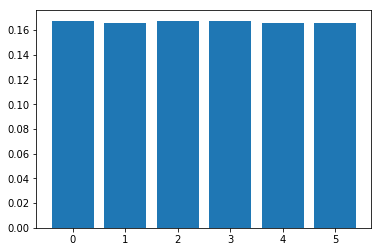

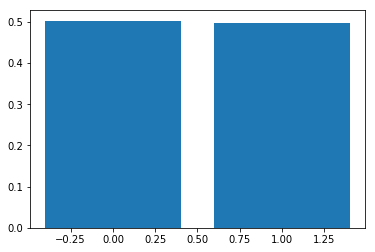

In [5]:
plt.bar(range(0,6),px)
plt.figure(2)
plt.bar(range(0,2),py)


## Joint Probability
We compute the joint probability of the two random variables. Pr(x,y)
If we observe multiple paired instances of x and y, then some combinations of the two outcomes occur more frequently than
others.
The total probability of all outcomes (summing over discrete variables and integrating over continuous ones) is always one.

[[0.08455 0.08299]
 [0.08347 0.08252]
 [0.08431 0.08315]
 [0.08349 0.08385]
 [0.08385 0.08219]
 [0.08312 0.08251]]
(6, 2)
0.9999999999999999


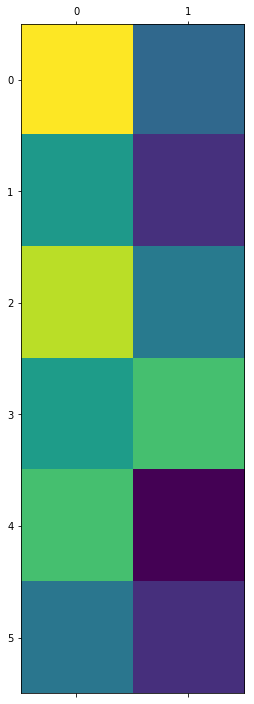

In [6]:
def PrJoint(x,y):
    n_cases_x=np.unique(x).shape[0]
    n_cases_y=np.unique(y).shape[0]
    res=np.zeros((n_cases_x,n_cases_y))
    for i in range(len(x)):
        res[x[i],y[i]]=res[x[i],y[i]]+1
    res/=float(len(x))
    return res
pxy=PrJoint(x,y)
print(pxy)
print(pxy.shape)
print(pxy.sum())
plt.matshow(pxy)

## Marginalization : Also called the sum rule

We can recover the probability distribution of any single variable from a joint
distribution by summing (discrete case) or integrating (continuous case) over all
the other variables.

$$Pr(x)=\sum_{y^* \in \Gamma} Pr(x,y=y^*)$$
$\Gamma$ is the set of all possible values that $y$ can take (0 and 1 here).

In [7]:

def PrMarginalizationgiveny(pxy):
    return pxy.sum(axis=1)
   
pxx=PrMarginalizationgiveny(pxy)
print("Pr(x)=",px[0:6])
print(px.shape)
print(px.sum())
print("Marginalization of Pr(x,y) according to y=",pxx[0:6])
print(pxx.shape)
print(pxx.sum())

Pr(x)= [0.16754 0.16599 0.16746 0.16734 0.16604 0.16563]
(6,)
1.0
Marginalization of Pr(x,y) according to y= [0.16754 0.16599 0.16746 0.16734 0.16604 0.16563]
(6,)
1.0


## Conditional probability : The product rule

The conditional probability of x given that y takes value y* tells us the relative
propensity of the random variable x to take different outcomes given that the
random variable y is fixed to value y*.

We compute the conditional probability x given y. 
$$Pr(x|y) = \dfrac{Pr(x,y)}{Pr(y)}$$

Pr(x|y)= [[0.16816166 0.16691137]
 [0.16601364 0.16596609]
 [0.16768432 0.16723316]
 [0.16605342 0.16864102]
 [0.16676943 0.16530239]
 [0.16531753 0.16594598]]
(6, 2)
1.0
1.0


<BarContainer object of 6 artists>

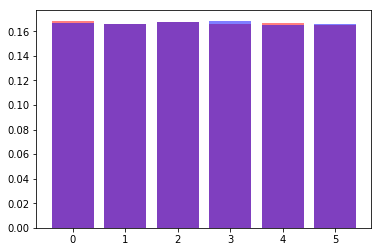

In [8]:

def Prxgiveny(pxy):
    res = np.zeros((pxy.shape[0],pxy.shape[1]))
    for ystar in range(pxy.shape[1]):
        pxystar= pxy[:,ystar]
        pystar=pxy[:,ystar].sum()
        res[:,ystar] = pxystar/pystar
    return res

pxgiveny=Prxgiveny(pxy)
print("Pr(x|y)=",pxgiveny)
print(pxgiveny.shape)
print(pxgiveny[:,0].sum())
print(pxgiveny[:,1].sum())
plt.figure(3)
plt.bar(range(0,6),pxgiveny[:,0],color='red',alpha=0.5)
plt.bar(range(0,6),pxgiveny[:,1],color='blue',alpha=0.5)


## Remark: Pr(x|y=0) is nearly equal to Pr(x|y=1). Pr(x|y)=Pr(x)

The coin value brings no information about the dice value. So x and y are indepent.
## Bayes rule to compute Pr(y|x). Also called the posterior distribution 

From the product rule, together with the symmetry property Pr(x,y) = Pr(y,x), we immediately obtain the following relationship between conditional probabilities.
$$Pr(x,y)=Pr(y,x) $$
$$Pr(x[y)Pr(y)=Pr(y[x)Pr(x) $$
$$Pr(y[x)=\dfrac{Pr(x[y)Pr(y)}{Pr(x)} $$

Pr(x)=evidence, Pr(x|y)=likelihood, Pr(y)=prior

Pr(y|x)=
[[0.5046556  0.4953444 ]
 [0.50286162 0.49713838]
 [0.50346351 0.49653649]
 [0.49892435 0.50107565]
 [0.5049988  0.4950012 ]
 [0.50184145 0.49815855]]
(6, 2)
1.0


<BarContainer object of 2 artists>

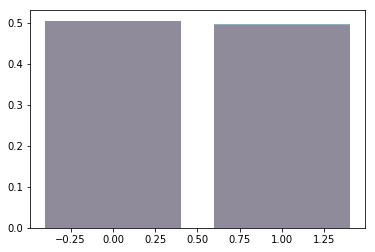

In [9]:
def BayesRule(pxgiveny,px,py):
    num=np.multiply(pxgiveny,py.T)
    pygivenx=num[:,].copy()
    pygivenx[:,0]=num[:,0]*(1/px)
    pygivenx[:,1]=num[:,1]*(1/px)
    return pygivenx

pygivenx=BayesRule(pxgiveny,px,py)
print("Pr(y|x)=")
print(pygivenx[0:6])
print(pygivenx.shape)
print(pygivenx[0,].sum())
plt.bar(range(0,2),pygivenx[0,:],alpha=0.25,color='red')
plt.bar(range(0,2),pygivenx[1,:],alpha=0.25,color='blue')
plt.bar(range(0,2),pygivenx[2,:],alpha=0.25,color='green')



## Remark: observing the dice value does not help to predict the coin value

Pr(y|x)=0.5 for all values of x

# Application : Binary Image Segmentation (Skin/Not Skin pixel). 

## Binary classification 

An image is composed of pixels. Each pixel is a discrete scalar value taking its value from 0 to 255. The value denotes the grey level of the pixel. 
For example, we might wish to classify a pixel as belonging to a skin or non-skin region based on observing just the pixel value.
We will consider the case where the observed measurement x is discrete value ranging from 0 to 255 modeled by a caterortical distribution, and the world state y is also discrete and can take one of two values {0,1}. 



$\mathcal{D}= \{x^{(j)},y^{(j)}\}_{j=1}^N$ with $N$ the number of pair samples.

$x^{(j)} \in \mathcal{S}$ is a value taken by the $j^{th}$ pixel. $\textbf{Or x for short when the index does not matter}$.

Let us define $D=|\mathcal{S}|=256$. $D$ is the size of the set of all possible pixel values. The number of possible pixel values \{0,1,2,3, $\cdots$,255\}.


$y^{(j)} \in \mathcal{E}$ is a world state value. A given class. $\textbf{Or y for short when the index does not matter}$.

$\mathcal{E}$ is the set of all possible prediction values \{0,1\} {not skin,skin}. 

Let us define $K=|\mathcal{E}|$. $K$ is the number of classes (K=2).


# Discriminative and Generative models

In particular, we distinguish between generative models and discriminative models.
For generative models, we build a probability model of the data and parameterize
it by the scene content. For discriminative models, we build a probability model
of the scene content and parameterize it by the data.

Models relating the data $x$ to the target $y$ fall into one of two categories. We either:
1. model the contingency of the target state on the data $Pr(y|x)$ or
2. model the contingency of the data on the world state $Pr(x|y)$.

The first type of model is termed discriminative. The second is termed generative;

The target $y$ can be a class label ("cat") if we are dealing with a classification problem.

1. In the discriminative model, we choose an appropriate form for the distribution $Pr(y)$
over the target state. The models may also depends on a set of parameters $\Theta$.
Since the distribution over the state depends on both the data and these parameters,
we write it as $Pr(y|x,\Theta)$ and refer to it as the posterior distribution.
The goal of the learning algorithm is to fit the parameters $\Theta$ using paired training
data $\{x_i,y_i\}_{i=1}^M$. This can be done using the maximum likelihood (ML), maximum
a posteriori (MAP), or Bayesian approaches.

2. In the generative model, we choose the form for the distribution $Pr(x)$ over the data. The generative model can depend on parameters, it as $Pr(x|y,\Theta)$ and refer to it as the $likelihood$. In inference, we aim to compute the posterior distribution $Pr(y|x)$. To this end we specify a prior $Pr(\Theta)$ over the target state and then use Bayes' rule.

Pr(x|y) is called a generative model. It tries to model the distribution of x (the data).

Pr(y|x) is a discriminative model if the distribution of x is never computed. It does not model x. It tries directly to discriminate y according to x. 

## Learning
We want to find the parameters ($\Theta$) such that the probability distribution fits the data.

## Inference

We take a new set of measurements or a new data : $𝑥^{(𝑛𝑒𝑤)}$ and we use the model to tell us about the world state.
We want to make a prediction from $𝑥^{(𝑛𝑒𝑤)}$  (to infer from $𝑥^{(𝑛𝑒𝑤)}$ ). We take a datum $𝑥^{(𝑛𝑒𝑤)}$ and use it to infer the state of the world $𝑦$.


# Naive Bayes Classification
We want to learn a generative model (Pr(x|y) and we want to question this model to tell us something about the world state (is the pixel a skin pixel or not ?). This questionning phase is called inference. The generative model will be learned by maximum of likelihood and the inference step will be achieved by Maximum a postriori (MAP).
## Learning by maximum of likelihood
We learning the generative model $Pr(x|y,\Theta)$.


We define $\Theta=\{\Lambda,\Gamma\}$ as a set of 2 kind of parameters.

1 . Let us express the joint probability of the data set 𝒟.  Assuming each data sequence was drawn independently from the distribution (Independent and identically distributed (i.i.d) ) !!! The Naive Bayes model is :
$$Pr(\mathcal{D}|\Theta)=  Pr(y^{(1)},\cdots,y^{(N)};x^{(1)},\cdots,x^{(N)}|\Theta)$$
$$Pr(y^{(1)},\cdots,y^{(N)};x^{(1)},\cdots,x^{(N)})=Pr(x^{(1)},\cdots,x^{(N)}|y^{(1)},\cdots,y^{(N)}).Pr(y^{(1)},\cdots,y^{(N)})$$

$$Pr(y^{(1)},\cdots,y^{(N)};x^{(1)},\cdots,x^{(N)}|\Theta)= \bigg[ \prod_{j=1}^N Pr(x^{(j)}|y^{(j)},\Lambda) \bigg]  \bigg[ \prod_{j=1}^N Pr(y^{(j)}|\Gamma) \bigg] = \bigg[ \prod_{j=1}^N Pr(x^{(j)}|y^{(j)},\Lambda) Pr(y^{(j)}|\Gamma) \bigg]  $$


2 . Let us fit the probability model by the maximum of likelihood

$$\hat{\Theta}=arg \max_\Theta  \prod_{j=1}^N \bigg[ Pr(x^{(j)}|y^{(j)},\Lambda) Pr(y^{(j)}|\Gamma) \bigg] $$

$$\hat{\Lambda}=arg \max_{\Lambda}  \prod_{j=1}^N \bigg[ Pr(x^{(j)}|y^{(j)},\Lambda)  \bigg]$$

$$\hat{\Gamma}=arg \max_{\Gamma}  \prod_{j=1}^N \bigg[ Pr(y^{(j)}|\Gamma) \bigg]$$


## Inference by Maximum a postriori (MAP)
From the product rule, together with the symmetry property Pr(x,y) = Pr(y,x), we immediately obtain the following relationship between conditional probabilities.
$$Pr(y,x)=Pr(x,y) $$
$$Pr(y[x)Pr(x) =Pr(x[y)Pr(y)$$
$$Pr(y[x)=\dfrac{Pr(x[y)Pr(y)}{Pr(x)} $$


Pr(x)=evidence, Pr(x|y)=likelihood, Pr(y)=prior


$$\hat{y}=arg \max_y Pr(y[x,\hat{\Theta})$$
$$\hat{y}=arg \max_y Pr(x[y,\Lambda)Pr(y,\Gamma) $$



# Let' get some data
# The data sets :
![Graph Convolution](https://cloud.githubusercontent.com/assets/5456665/20896606/cbaa3d56-bb48-11e6-9277-c236eaf23b9b.png)

The data can be downloaded from :

https://github.com/MinhasKamal/SkinDetector/tree/master/data

# Reading some data. Getting in touch with our data

(180, 150, 3)
[ 8  8 10]
255
(443, 664, 3)
[175  37  37]
255


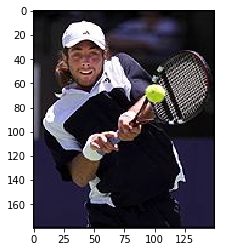

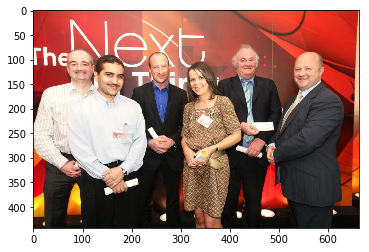

In [10]:
im=Image.imread('./data/image/image (1).jpg')
plt.figure(1)
plt.imshow(im)
print(im.shape)
print(im[5,5])
print(im.max())

im=Image.imread('./data/image/image (84).jpg')
plt.figure(2)
plt.imshow(im)
print(im.shape)
print(im[5,5])
print(im.max())


# From Color to Gray level image

(443, 664)
83


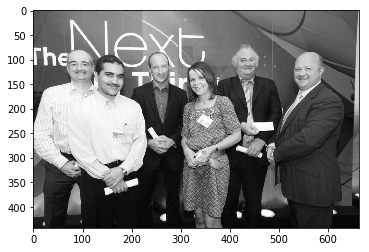

In [11]:
def ColorToGrayImage(im):
    im1=np.around(im.mean(axis=2))
    im1=im1.astype(int)
    return im1
    
im1=ColorToGrayImage(im)

plt.figure(1)
plt.imshow(im1, cmap="gray")
print(im1.shape)
print(im1[5,5])

# Reading the mask of skin pixels


(443, 664, 4)
[0. 0. 0. 1.]
1.0
(443, 664)
0.0
1.0


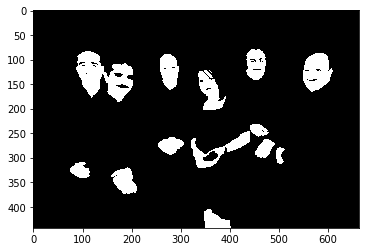

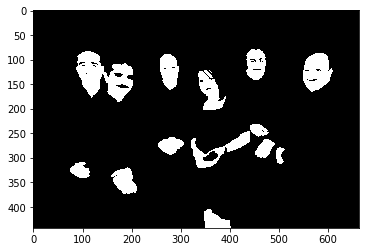

In [12]:
im=Image.imread('./data/mask/mask (84).png')
plt.figure(1)
plt.imshow(im)
print(im.shape)
print(im[5,5])
print(im.max())

plt.figure(2)
im=im[:,:,0:2]
im1=im.max(axis=2)
plt.imshow(im1, cmap="gray")
print(im1.shape)
print(im1[5,5])
print(im1.max())


# Let us create the Training set $\mathcal{D}$

## We read each image and each mask. Each matrix (image or mask) is transformed to a vector (flatten). Each image as a vector is concatenated to obtain a huge vector with all the pixel values. Each mask as a vector is concatenated to obtain a huge vector with all the class values.

In [13]:
nbimages=87

allx=np.array([])
ally=np.array([])

i=1

print('./data/image/image ('+str(i)+').jpg')
im=Image.imread('./data/image/image ('+str(i)+').jpg')
im=ColorToGrayImage(im)
x=im.flatten()
allx=x


mask=Image.imread('./data/mask/mask ('+str(i)+').png')
mask=mask.max(axis=2)
mask=mask.astype(int)
y=mask.flatten()
ally=y

for i in range(2,nbimages+1):
    
    if i!=53:
        print('./data/image/image ('+str(i)+').jpg')

        im=Image.imread('./data/image/image ('+str(i)+').jpg')
        im=ColorToGrayImage(im)
        print(im.shape)
        x=im.flatten()
        allx=np.concatenate((allx, x))


        mask=Image.imread('./data/mask/mask ('+str(i)+').png')
        print(mask.shape)
        if len(mask.shape)>=3:
            mask=mask[:,:,0:2]
            mask=mask.max(axis=2)
        mask=mask.astype(int)
        print(mask.shape)
        y=mask.flatten()
        ally=np.concatenate((ally, y))
    
db=[allx,ally]
print("Number of pixels x=",allx.shape)
print("Number of y values=",ally.shape)


./data/image/image (1).jpg
./data/image/image (2).jpg
(196, 300)
(196, 300, 3)
(196, 300)
./data/image/image (3).jpg
(360, 480)
(360, 480, 3)
(360, 480)
./data/image/image (4).jpg
(600, 800)
(600, 800, 3)
(600, 800)
./data/image/image (5).jpg
(190, 256)
(190, 256)
(190, 256)
./data/image/image (6).jpg
(325, 370)
(325, 370, 3)
(325, 370)
./data/image/image (7).jpg
(586, 872)
(586, 872, 3)
(586, 872)
./data/image/image (8).jpg
(588, 872)
(588, 872, 3)
(588, 872)
./data/image/image (9).jpg
(240, 352)
(240, 352, 3)
(240, 352)
./data/image/image (10).jpg
(264, 352)
(264, 352, 3)
(264, 352)
./data/image/image (11).jpg
(264, 352)
(264, 352, 3)
(264, 352)
./data/image/image (12).jpg
(264, 352)
(264, 352, 3)
(264, 352)
./data/image/image (13).jpg
(270, 360)
(270, 360, 3)
(270, 360)
./data/image/image (14).jpg
(264, 352)
(264, 352, 3)
(264, 352)
./data/image/image (15).jpg
(264, 352)
(264, 352, 3)
(264, 352)
./data/image/image (16).jpg
(264, 352)
(264, 352, 3)
(264, 352)
./data/image/image (17).

# Let us compute the Pr(x) and Pr(y) distributions. Both are modeled as Categorical distributions. Categorical distributions are fitted to the data by the Maximum Likelihood technique (See above for the whole details) . Concequently, we obtain for each distribution a normalized histogram.


In [14]:
#This function computes the probability distribution
def Pr(x,nbbins):
    n_cases=nbbins
    res=np.zeros((n_cases))
    for i in x:
        res[i]=res[i]+1
    res/=float(len(x))
    return res


px=Pr(allx,256)
py=Pr(ally,2)
print(px.shape)
print(px.sum())
print(py[0:2])
print(py.shape)
print(py.sum())


(256,)
1.0
[0.85691306 0.14308694]
(2,)
1.0


# Let us plot the distributions

<BarContainer object of 2 artists>

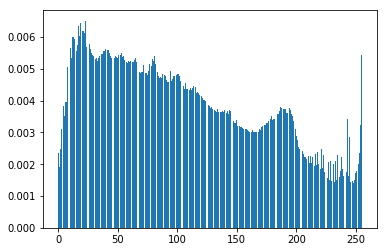

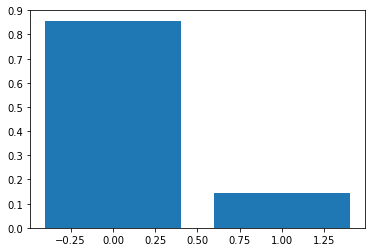

In [15]:

plt.bar(range(0,256),px)
plt.figure(2)
plt.bar(range(0,2),py)


### The skin class (y=1) has less samples only 14%
## Compute joint distribution Pr(x,y)

In [16]:
def PrJoint(x,y):
    n_cases_x=256
    n_cases_y=2
    res=np.zeros((n_cases_x,n_cases_y))
    for i in range(len(x)):
        res[x[i],y[i]]=res[x[i],y[i]]+1
    res/=float(len(x))
    return res


pxy=PrJoint(allx,ally)
print(pxy.shape)
print(pxy.sum())


(256, 2)
1.0


# Let us compute the Conditional probability Pr(x|y) : Learning phase by maximum of likelihood.

Pr(x|y)=
(256, 2)
0.9999999999999998
1.0


<BarContainer object of 256 artists>

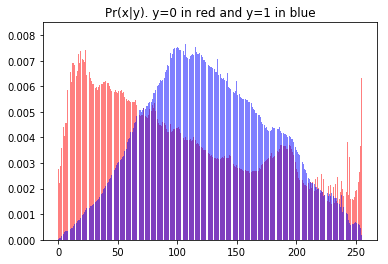

In [17]:
def Prxgiveny(pxy):
    res = np.zeros((pxy.shape[0],pxy.shape[1]))
    for ystar in range(pxy.shape[1]):
        pxystar= pxy[:,ystar]
        pystar=pxy[:,ystar].sum()
        res[:,ystar] = pxystar/pystar
    return res

pxgiveny=Prxgiveny(pxy)
print("Pr(x|y)=")
print(pxgiveny.shape)
print(pxgiveny[:,0].sum())
print(pxgiveny[:,1].sum())
plt.figure(3)
plt.title("Pr(x|y). y=0 in red and y=1 in blue")
plt.bar(range(0,256),pxgiveny[:,0],color='red',alpha=0.5)
plt.bar(range(0,256),pxgiveny[:,1],color='blue',alpha=0.5)


# Histograms seem to be overlapped so the classification of a pixel as being skin or not might be hard .....

## Inference : Compute posterior distribution Pr(y|x) thanks to baye"s rule

(256, 2)
0.9999999999999999


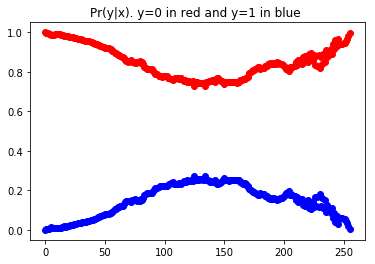

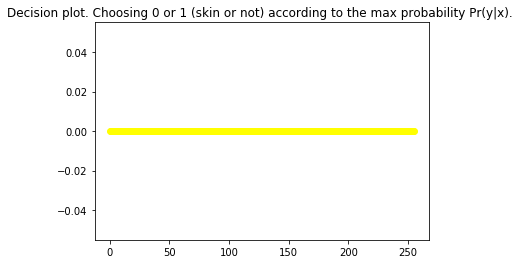

In [18]:
def BayesRule(pxgiveny,px,py):
    num=np.multiply(pxgiveny,py.T)
    pygivenx=num[:,].copy()
    pygivenx[:,0]=num[:,0]*(1/px)
    pygivenx[:,1]=num[:,1]*(1/px)
    return pygivenx

pygivenx=BayesRule(pxgiveny,px,py)

print(pygivenx.shape)
print(pygivenx[150,:].sum())
plt.figure(4)
plt.title("Pr(y|x). y=0 in red and y=1 in blue ")
plt.plot(pygivenx[:,0],'ro',c='red')
plt.plot(pygivenx[:,1],'ro',c='blue')
plt.figure(5)
plt.title("Decision plot. Choosing 0 or 1 (skin or not) according to the max probability Pr(y|x). ")
plt.plot(pygivenx.argmax(axis=1),'ro',c='yellow')

## Maximum a posteriori (MAP) classification. 
## Use the posterior distribution to classify pixel as skin or not
$$max_y Pr(y|x)$$

In [19]:
ypred=pygivenx[allx].argmax(axis=1)
classif=np.abs(ypred-ally).sum()
print("Number of incorrectly classify pixels:",classif)
print("Ratio of incorrectly classify pixels (error rate):",classif/len(ypred))

Number of incorrectly classify pixels: 2723044
Ratio of incorrectly classify pixels (error rate): 0.14308693702006484


# The model always predicts 0 !!! because classes are overlapped that is to say skin and no skin pixels are similar in addition skin pixels(y=1) are less represented (rare). The best way to minimize the error of classification is to always predict 0 ...

# Maximum likelihood skin detector 
$$ max_y Pr(x|y)$$

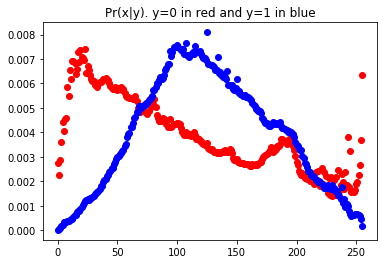

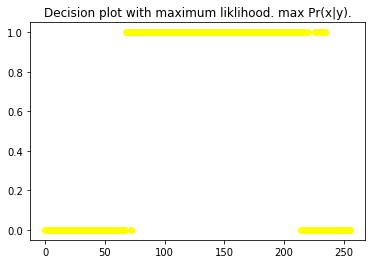

In [20]:
plt.figure(3)
plt.title("Pr(x|y). y=0 in red and y=1 in blue")
plt.plot(pxgiveny[:,0],'ro',c='red')
plt.plot(pxgiveny[:,1],'ro',c='blue')
plt.figure(4)
plt.title("Decision plot with maximum liklihood. max Pr(x|y).")
plt.plot(pxgiveny.argmax(axis=1),'ro',c='yellow')




## Maximum likelihood classification. 
## Use the likelihood  distribution to classify pixel as skin or not
$$max_y Pr(x|y)$$

In [21]:
ypred=pxgiveny[x].argmax(axis=1)
classif=np.abs(ypred-y).sum()
print("Number of incorrectly classify pixels:",classif)
print("Ratio of incorrectly classify pixels (error rate):",classif/len(ypred))

Number of incorrectly classify pixels: 479352
Ratio of incorrectly classify pixels (error rate): 0.6935069444444445


## Skin and not skin pixels are treated equally (equal probability) that leads to a higher classification error.

# Bottom line : Gray level pixel value, on its own, is not enough to distinguish between skin and not skin.

# Let us see what the pixel neighbourhood can be helpful to discriminate between skin and not skin

# This brings us to Hidden Markov Model where the dicision for a given pixel will depend on the previous one.

# Problem definition : 
$\mathcal{D}= \{x^{(j)},y^{(j)}\}_{j=1}^N$ with $N$ the number of pair samples.

$x^{(j)} \in \mathcal{S}^{M \times 1}$ is a sequence of $M$ pixels that is to say a line in the image. A pixel takes its value in the set $\mathcal{S}=\{0,1,2,\cdots,255\}$.

$\mathcal{S}$ is the set of gray level. $\mathcal{S}=\{0,1,2,\cdots,255\}$.

$x^{(j)}_i \in \mathcal{S}$ is a pixel value. $x_i$ for short when there is no need to specify the index of the sequence.

Let us define $D=|\mathcal{S}|=256$. 

$y^{(j)} \in \mathcal{E}^{M \times 1}$ is a sequence of skin or not skin value. A sequence of 0 or 1 denoting if a pixel is a skin or not a skin pixel. A class decision takes its value in the set $\mathcal{E}$. 

$\mathcal{E}=\{0,1\}$ is the set of the two classes. 

$y^{(j)}_i \in \mathcal{E}$ is a class value. $y_i$ for short when there is no need to specify the index of the sequence.

Let us define $K=|\mathcal{E}|=2$. The number of classes.

### We want to find a function $f: \mathcal{S}^{M \times 1} \to \mathcal{E}^{M \times 1}$.


# A sequence model : HMM
Let us try to model our sequence thanks to a HMM model. 
![Graph Convolution](http://romain.raveaux.free.fr/document/hmmmodel.PNG)

# Inference with HMM : Maximum a posteriori
We take a new set of measurements ($x^{new}$) and use the model to tell us about the world state ($y$).
The HMM is generative model because it models $Pr(x_i|y_i)$ where we want $Pr(y_i|x_i)$.
Inference with a generative model can be achieved by the baye’s rule. We obtain the so called posterior distribution. 
![Graph Convolution](http://romain.raveaux.free.fr/document/MAPHMM.PNG)
Finding the maximum of the posterior distribution is known as Maximum a posteriori (**MAP**).

# Inference with HMM : the optimization problem
Let us define the optimization problem to find the MAP.
$$Pr(y_1,\cdots,y_M|x^{new}_1,\cdots,x^{new}_M)=\frac{Pr(x_1^{new},\cdots,x_M^{new}|y_1,\cdots,y_M).Pr(y_1,\cdots,y_M)}{Pr(x_1^{new},\cdots,x_M^{new})}$$
$$\hat{y_1},\cdots,\hat{y_M}=arg \max_{y_1,\cdots,y_M} \bigg[Pr(y_1,\cdots,y_M|x^{new}_1,\cdots,x^{new}_M) \bigg]$$
$$\hat{y_1},\cdots,\hat{y_M}=arg \max_{y_1,\cdots,y_M} \bigg[ Pr(x_1^{new},\cdots,x_M^{new}|y_1,\cdots,y_M).Pr(y_1,\cdots,y_M) \bigg]$$

$$\hat{y_1},\cdots,\hat{y_M}=arg \max_{y_1,\cdots,y_M} \bigg[ \prod_{i=1}^M Pr(x_i^{new}|y_i) .Pr(y_1)\prod_{i=2}^M Pr(y_i|y_{i-1}) \bigg]$$

$$\hat{y_1},\cdots,\hat{y_M}=arg \min_{y_1,\cdots,y_M} - \log \bigg[ Pr(x_1^{new},\cdots,x_M^{new}|y_1,\cdots,y_M).Pr(y_1,\cdots,y_M) \bigg]$$

$$\hat{y_1},\cdots,\hat{y_M}=arg \min_{y_1,\cdots,y_M} \bigg[ -\sum_{i=1}^M Pr(x_i^{new}|y_i) - Pr(y_1) - \sum_{i=2}^M Pr(y_i|y_{i-1}) \bigg]$$
$$\hat{y_1},\cdots,\hat{y_M}=arg \min_{y_1,\cdots,y_M} \bigg[  \sum_{i=1}^M U_i(y_i) + \sum_{i=2}^M P_i(y_i,y_{i-1}) \bigg]$$
$$U_i(y_i) =-\log [ Pr(x_i^{new}|y_i) ]$$
$$P_i(y_i,y_{i-1}) =-\log [ Pr(y_i|y_{i-1}) ]$$

# Solving the optimization problem
The MAP problem can be solved thanks to the Viterbi Algorithm which complexity is $O(MK^2)$ where $K$ is the number of states for $y_{i,j}$ variables. 

## Viterbi Algorithm
The algorithm' concept :
$S_{1,k}=U_1(y_1=k,x^{new}_1)$

$S_{2,k}=U_2(y_2=k,x^{new}_2)+ \min_l [S_{1,l}+P_2(y_1=l,y_2=k)] $

$S_{i,k}=U_i(y_i=k,x^{new}_i)+ \min_l [S_{i-1,l}+P_i(y_{i-1}=l,y_i=k)] $

$\hat{y}_{M}=argmin_k [S_{M,k}] $

# Learning with HMM
##  Modeling the distributions
So far there is no learning.
1. We just give a sequence (x) and output the labeled sequence (y)
2. Where learning can be introduced ?
3. Where are the parameters ?

Supervised learning
1. Relatively simple. We first isolate the part of the model that we want to learn : $Pr(x_i|y_i;\lambda)$ and $Pr(y_i|y_{i-1};\gamma)$. For example, we might learn the parameters $\lambda$, $\gamma$ from paired examples of $x_i$ and $y_i$. 

2. We model $Pr(x_i|y_i)$ as being categorically distributed, where the parameters depend $y_i$, so that $Pr(x_i|y_i)=Cat_{x_i}[\lambda]$. Categorical distribution is well suited for words because words are by definition categorial values.  $\lambda \in [0, 1]^{K \times D}$. 

3. We model $Pr(y_i|y_{i-1})$ as being categorically distributed, where the parameters depend on the previous sign $y_{i-1}$
so that $Pr(y_i|y_{i-1}=k)=Cat_{y_i}[\gamma]$.  In our case, $\gamma \in [0, 1]^{K \times K}$.


### A non-positional model
We model $Pr(x_i|y_i)$ as we would do it in Natural Language Processing or Computer Vision fields. It means that we are thinking in terms of a time invariant model. $Pr(x_i|y_i)$ does not depends on the time step.


### Limitations of the HMM : 
1. Markov Assumption : The future depends only on the present. Also known as firs order Markov chain
2. It is a generative model. We want to predict $y_i$ and instead we generate $x_i$
3. $Pr(x_i|y_i)$ and $Pr(y_i|y_{i-1})$ holds parameters that are shared through time. All time steps have the same parameters. Corresponding to the assumption of a stationary time series.

## Learning HMM by Maximum Likelihood
Let us denote $W= \{\lambda, \gamma \}$


1 . Let us express the joint probability of the data set 𝒟 . For one input and one output, the HMM model is :
$$Pr(y_1,\cdots,y_M;x_1,\cdots,x_M)=Pr(x_1,\cdots,x_M|y_1,\cdots,y_M).Pr(y_1,\cdots,y_M)$$
$$Pr(y_1,\cdots,y_M;x_1,\cdots,x_M|W)= \bigg[ \prod_{i=1}^M Pr(x_i|y_i,\lambda) \bigg] \bigg[ Pr(y_1)\prod_{i=2}^M Pr(y_i|y_{i-1}, \gamma)\bigg] $$

2 . For the whole data set : Assuming each data sequence was drawn independently from the distribution (Independent and identically distributed (i.i.d) ) !!!

$$Pr(\mathcal{D}|W)=  Pr(y^{(1)},\cdots,y^{(N)};x^{(1)},\cdots,x^{(N)}|W)$$
$$Pr(\mathcal{D}|W)= \prod_{j=1}^N\bigg[Pr(y^{(j)}_1,\cdots,y^{(j)}_M;x^{(j)}_1,\cdots,x^{(j)}_M|W)\bigg]$$
$$Pr(\mathcal{D}|W)= \prod_{j=1}^N\bigg[ \prod_{i=1}^M \bigg( Pr(x^{(j)}_i|y^{(j)}_i,\lambda) \bigg)  Pr(y^{(j)}_1)\prod_{i=2}^M \bigg( Pr(y^{(j)}_i|y^{(j)}_{i-1}, \gamma)\bigg)\bigg] $$
$$\hat{W}=arg \max_W  Pr(\mathcal{D}|W) $$
$$\hat{W}=arg \max_W   \prod_{j=1}^N\bigg[
Pr(y^{(j)}_1,\cdots,y^{(j)}_M;x^{(j)}_1,\cdots,x^{(j)}_M|W)\bigg] $$

3 . Let us fit the probability model by the maximum of likelihood

$$\hat{W}=arg \max_W  \prod_{j=1}^N\bigg[ \prod_{i=1}^M \bigg( Pr(x^{(j)}_i|y^{(j)}_i,\lambda) \bigg)  Pr(y^{(j)}_1)\prod_{i=2}^M \bigg( Pr(y^{(j)}_i|y^{(j)}_{i-1}, \gamma)\bigg)\bigg] $$

$$\hat{\lambda}=arg \max_{\lambda}  \prod_{j=1}^N\bigg[ \prod_{i=1}^M \bigg( Pr(x^{(j)}_i|y^{(j)}_i,\lambda) \bigg)  \bigg]$$


$$\hat{ \gamma}=arg \max_{ \gamma}  \prod_{j=1}^N\bigg[ Pr(y^{(j)}_1)\prod_{i=2}^M \bigg( Pr(y^{(j)}_i|y^{(j)}_{i-1}, \gamma)\bigg)  \bigg]$$



# Let us create the training database $\mathcal{D}$ according the sequence-based definition

In [22]:


allx=[]
ally=[]

for i in range(1,nbimages+1):
    
    if i!=53:
        print('./data/image/image ('+str(i)+').jpg')

        im=Image.imread('./data/image/image ('+str(i)+').jpg')
        im=ColorToGrayImage(im)
        for j in range(im.shape[0]):
            x=im[j,:]
            allx.append(x)
            


        mask=Image.imread('./data/mask/mask ('+str(i)+').png')
        if len(mask.shape)>=3:
            mask=mask[:,:,0:2]
            mask=mask.max(axis=2)
        mask=mask.astype(int)
        for j in range(mask.shape[0]):
            y=mask[j,:]
            ally.append(y)
        
        
db=[allx,ally]
print("Number of x sequences=",len(allx))
print("Number of y sequences=",len(ally))


./data/image/image (1).jpg
./data/image/image (2).jpg
./data/image/image (3).jpg
./data/image/image (4).jpg
./data/image/image (5).jpg
./data/image/image (6).jpg
./data/image/image (7).jpg
./data/image/image (8).jpg
./data/image/image (9).jpg
./data/image/image (10).jpg
./data/image/image (11).jpg
./data/image/image (12).jpg
./data/image/image (13).jpg
./data/image/image (14).jpg
./data/image/image (15).jpg
./data/image/image (16).jpg
./data/image/image (17).jpg
./data/image/image (18).jpg
./data/image/image (19).jpg
./data/image/image (20).jpg
./data/image/image (21).jpg
./data/image/image (22).jpg
./data/image/image (23).jpg
./data/image/image (24).jpg
./data/image/image (25).jpg
./data/image/image (26).jpg
./data/image/image (27).jpg
./data/image/image (28).jpg
./data/image/image (29).jpg
./data/image/image (30).jpg
./data/image/image (31).jpg
./data/image/image (32).jpg
./data/image/image (33).jpg
./data/image/image (34).jpg
./data/image/image (35).jpg
./data/image/image (36).jpg
.

# Let us code

### Let us compute the probability distribution $Pr(y_i)=Cat_{x_i}[\theta]$.  $\theta \in [0,1]^{1 \times K}$. 

In [23]:
K=2
thetaa=np.zeros((1,K))
for i in range(len(ally)):
    y=ally[i]
    for j in range(len(y)):
        oneclass=y[j]
        thetaa[0,oneclass]=thetaa[0,oneclass]+1
        
print(thetaa)
print("We should normalize the thetaa to sum to one but I need it not normalize Pr(x_i|y_i) later")
print(thetaa/thetaa.sum())

[[16307652.  2723044.]]
We should normalize the thetaa to sum to one but I need it not normalize Pr(x_i|y_i) later
[[0.85691306 0.14308694]]


### Let us compute the probability distribution $Pr(x_i|y_i)=Cat_{x_i}[\lambda]$.  $\lambda \in [0,1]^{K \times D}$. 


In [24]:
K=2
D=256
lambdaa=np.zeros((K,D))
for i in range(len(ally)):
    y=ally[i]
    x=allx[i]
    for j in range(len(y)):
        oney=y[j]
        onex=x[j]
        
        lambdaa[oney,onex]=lambdaa[oney,onex]+1


for k in range(K):
    lambdaa[k,:]/=thetaa[0,k]
print(lambdaa.sum(axis=1))

[1. 1.]


### Let us compute the probability distribution $Pr(y_i|y_{i-1}=k)=Cat_{y_i}[\gamma]$.  $\gamma \in \mathbb{R}^{K \times K}$.

In [25]:
gammaa=np.zeros((K,K))

for i in range(len(ally)):
    y=ally[i]
    for j in range(len(y)-1):
        oney=y[j]
        
        secondy=y[j+1]
        gammaa[oney,secondy]=gammaa[oney,secondy]+1

for k in range(0,K):
    gammaa[k,:]=gammaa[k,:]/gammaa[k,:].sum()
print(gammaa.sum(axis=1))

[1. 1.]


# Let us code the Viterbi Algorithm

The algorithm' concept :
$S_{1,k}=U_1(y_1=k,x^{new}_1)$

$S_{2,k}=U_2(y_2=k,x^{new}_2)+ \min_l [S_{1,l}+P_2(y_1=l,y_2=k)] $

$S_{i,k}=U_i(y_i=k,x^{new}_i)+ \min_l [S_{i-1,l}+P_i(y_{i-1}=l,y_i=k)] $

$\hat{y}_{M}=argmin_k [S_{M,k}] $


In [26]:

def Ui(yi,x):
    epsilon = 0.0000000001
    pr=-np.log((lambdaa[yi,x])+epsilon)
    return pr

def Pi(yi,yiminusone):
    epsilon = 0.0000000001
    return -np.log(gammaa[yiminusone,yi]+epsilon)

def FindMin(S,yi,i):
    minindex=-1
    minval=999999
    for l in range(0,K):
        vals=S[i-1,l]
        valp=Pi(yi,l)
        val=vals+valp
        if val < minval:
            minval=val
            minindex=l
    return minval,minindex

def Viterbi(xnew):
    sentencelength=len(xnew)

    S=np.zeros((sentencelength,K))
    Sindice=np.zeros((sentencelength,K))
    i=0
    x=xnew[i]
    for yi in range(0,K):
        S[i,yi]=Ui(yi,x)
    
    for i in range(1,sentencelength):
        x=xnew[i]
        for yi in range(0,K):
            minvall,minl=FindMin(S,yi,i)
            Sindice[i,yi]=minl
            S[i,yi]=Ui(yi,x)+minvall

    ypred=[]
    ycur=S[sentencelength-1,:].argmin()
    ypred.append(ycur)
    i=sentencelength-1
    while i >= 1:
        ycur=Sindice[i,int(ycur)]
        ypred.append(int(ycur))
        i=i-1
    ypred.reverse()
    return ypred
    

## Let us try the algorithm

In [27]:
x=allx[0]
print(x)
print("Let us call Viterbi")
ypred=Viterbi(x)
print(ypred)

y=ally[0]
print(y)

print("Let us compare y and ypred by a ratio of similarity")
score=np.sum(np.array(y)==np.array(ypred))/len(y)
print(score)


[1 1 1 2 2 1 1 1 1 1 1 1 2 2 2 3 2 2 2 2 2 1 1 1 1 1 2 1 2 2 2 7 5 6 6 5 4
 3 3 3 3 2 2 1 0 0 0 0 2 2 2 1 2 2 2 2 1 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 2 4 4 2 1 2 2 3 3 4 5 6 6 7 6 5 4 4 3 3 2 1 1 1 1 0 0 2 1 1
 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1
 0 0]
Let us call Viterbi
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

# Let us write some helpers 

In [28]:

def similaritymeasure(y,ypred):
    score=np.sum(np.array(y)==np.array(ypred))/len(y)
    return score
    


# Let us try our method on all the database

In [29]:
allscore=0
count=0
for i in range(len(allx)):
    x=allx[i]
    y=ally[i]
    ypred=Viterbi(y)
    score=similaritymeasure(y,ypred)
    allscore+=score
    count=count+1

allscore/=count
print("Classification rate=",allscore)

print("Number of incorrectly classify pixels:",classif*count)
print("Ratio of incorrectly classify pixels (error rate):",1-allscore)

Classification rate= 0.8551046911643868
Number of incorrectly classify pixels: 16327208472
Ratio of incorrectly classify pixels (error rate): 0.1448953088356132


### We get 85.5% of good recognition on the training data set. !!!!  It is similar than the Naive Bayes classifier. So knowing the previous decision (skin/not skin) is not very useful.

# Conclusion

1. We have implemented a Hidden Markov Model for binary segmentation.
2. The learning phase is achieved by modeling probability distributions as categorical distributions and parameters of these distructions are learned by Maximum Likelihood.
3. Inference is achieved by Maximum a posteriori thanks to the Viterbi algorithm







# Let us extend the concept from Gray level to RGB.

We briefly note that the RGB data are naturally discrete with $x^R, x^G, x^B\in \{0,1,\cdots,255\}$, and we could alternatively have based our skin detection model on this assumption. For example, modeling the three color channels independently,
the likelihoods become : 
$$Pr(x|y=k)=Cat_{x^R}[\lambda_k^R] \times Cat_{x^G}[\lambda_k^G]  \times Cat_{x^B}[\lambda_k^B]$$

We refer to the assumption that the elements of the data vector are independent as $naive$ $Bayes$. Of course, it is not necessarily valid in the real world. To model the joint distribution of the R,G, and B components, we might combine them to form one variable with $256^3$ entries and model this with a single categorical distribution. Unfortunately, this means we must learn $256^3$ parameters for each categorical distribution, and so it is more practical to quantize each channel to
fewer levels (say 8) before combining them together.


In [30]:
nbimages=87

allr=np.array([])
allg=np.array([])
allb=np.array([])
ally=np.array([])

i=1

print('./data/image/image ('+str(i)+').jpg')
im=Image.imread('./data/image/image ('+str(i)+').jpg')
r=im[:,:,0].flatten()
g=im[:,:,1].flatten()
b=im[:,:,2].flatten()
allr=r
allg=g
allb=b


mask=Image.imread('./data/mask/mask ('+str(i)+').png')
mask=mask.max(axis=2)
mask=mask.astype(int)
y=mask.flatten()
ally=y

for i in range(2,nbimages+1):
    
    if i!=53:
        print('./data/image/image ('+str(i)+').jpg')

        im=Image.imread('./data/image/image ('+str(i)+').jpg')
        r=im[:,:,0].flatten()
        g=im[:,:,1].flatten()
        b=im[:,:,2].flatten()
        allr=np.concatenate((allr, r))
        allg=np.concatenate((allg, g))
        allb=np.concatenate((allb, b))
        print(im.shape)
        

        mask=Image.imread('./data/mask/mask ('+str(i)+').png')
        print(mask.shape)
        if len(mask.shape)>=3:
            mask=mask[:,:,0:2]
            mask=mask.max(axis=2)
        mask=mask.astype(int)
        print(mask.shape)
        y=mask.flatten()
        ally=np.concatenate((ally, y))
    
print("Number of pixels r=",allr.shape)
print("Number of y values=",ally.shape)


./data/image/image (1).jpg
./data/image/image (2).jpg
(196, 300, 3)
(196, 300, 3)
(196, 300)
./data/image/image (3).jpg
(360, 480, 3)
(360, 480, 3)
(360, 480)
./data/image/image (4).jpg
(600, 800, 3)
(600, 800, 3)
(600, 800)
./data/image/image (5).jpg
(190, 256, 3)
(190, 256)
(190, 256)
./data/image/image (6).jpg
(325, 370, 3)
(325, 370, 3)
(325, 370)
./data/image/image (7).jpg
(586, 872, 3)
(586, 872, 3)
(586, 872)
./data/image/image (8).jpg
(588, 872, 3)
(588, 872, 3)
(588, 872)
./data/image/image (9).jpg
(240, 352, 3)
(240, 352, 3)
(240, 352)
./data/image/image (10).jpg
(264, 352, 3)
(264, 352, 3)
(264, 352)
./data/image/image (11).jpg
(264, 352, 3)
(264, 352, 3)
(264, 352)
./data/image/image (12).jpg
(264, 352, 3)
(264, 352, 3)
(264, 352)
./data/image/image (13).jpg
(270, 360, 3)
(270, 360, 3)
(270, 360)
./data/image/image (14).jpg
(264, 352, 3)
(264, 352, 3)
(264, 352)
./data/image/image (15).jpg
(264, 352, 3)
(264, 352, 3)
(264, 352)
./data/image/image (16).jpg
(264, 352, 3)
(264

<BarContainer object of 256 artists>

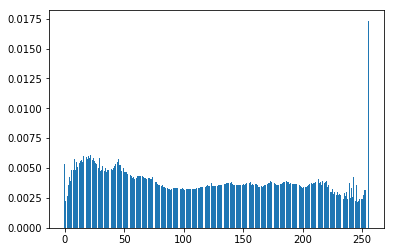

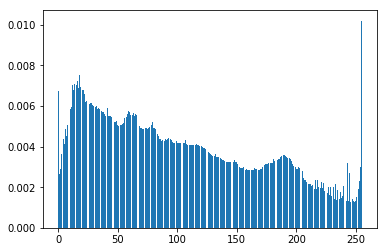

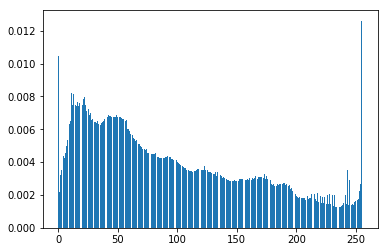

In [31]:
pr=Pr(allr,256)
pg=Pr(allg,256)
pb=Pr(allb,256)
py=Pr(ally,2)


plt.figure(1)
plt.bar(range(0,256),pr)

plt.figure(2)
plt.bar(range(0,256),pg)

plt.figure(3)
plt.bar(range(0,256),pb)


1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


<BarContainer object of 2 artists>

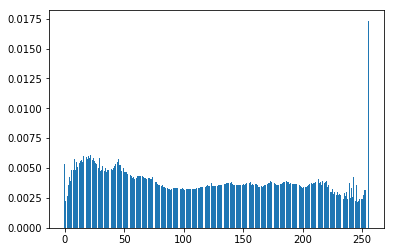

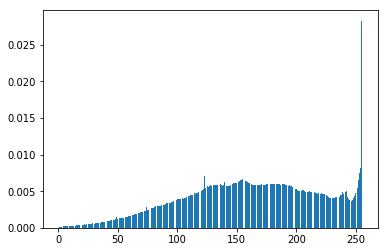

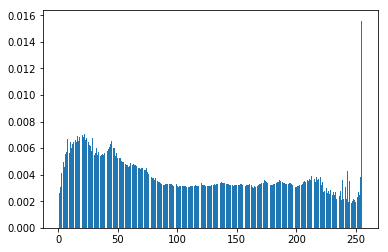

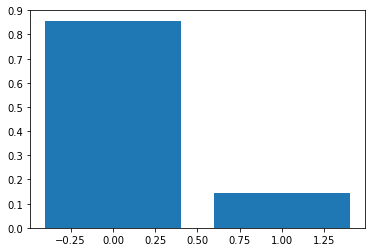

In [32]:
print(pr.sum())
print(pg.sum())
print(pb.sum())
#######################"
allryone=allr*ally
allryone = np.ma.masked_equal(allryone,0)
allryone = allryone.compressed()
allryone=allryone.astype(int)
prone=Pr(allryone,256)
print(prone.sum())

allryzero=(allr*(1-ally))
allryzero = np.ma.masked_equal(allryzero,0)
allryzero = allryzero.compressed()
allryzero=allryzero.astype(int)
przero=Pr(allryzero,256)
print(przero.sum())
#######################"

allryone=allg*ally
allryone = np.ma.masked_equal(allryone,0)
allryone = allryone.compressed()
allryone=allryone.astype(int)
pgone=Pr(allryone,256)
print(pgone.sum())

allryzero=(allg*(1-ally))
allryzero = np.ma.masked_equal(allryzero,0)
allryzero = allryzero.compressed()
allryzero=allryzero.astype(int)
pgzero=Pr(allryzero,256)
print(pgzero.sum())
#######################"

allryone=allb*ally
allryone = np.ma.masked_equal(allryone,0)
allryone = allryone.compressed()
allryone=allryone.astype(int)
pbone=Pr(allryone,256)
print(pbone.sum())

allryzero=(allb*(1-ally))
allryzero = np.ma.masked_equal(allryzero,0)
allryzero = allryzero.compressed()
allryzero=allryzero.astype(int)
pbzero=Pr(allryzero,256)
print(pbzero.sum())

plt.figure(1)
plt.bar(range(0,256),pr)
plt.figure(2)
plt.bar(range(0,256),prone)
plt.figure(3)
plt.bar(range(0,256),przero)
plt.figure(7)
plt.bar(range(0,2),py)




In [33]:
pxzero=przero[allr]*pgzero[allg]*pbzero[allb]
pxone=prone[allr]*pgone[allg]*pbone[allb]
pxzero=pxzero*py[0]
pxone=pxone*py[1]
pygivenx=np.array([pxzero,pxone])
print(pygivenx.shape)
ypred=pygivenx.argmax(axis=0)
print(ypred.shape)
print(ypred)
res=ally==ypred
print(res.shape)
print(res)
classif=res.sum()
print(classif)
print(len(allr))
error=len(allr)-classif
print("Number of incorrectly classify pixels:",error)
print("Ratio of incorrectly classify pixels (error rate):",(error)/len(allr))


(2, 19030696)
(19030696,)
[0 0 0 ... 0 0 0]
(19030696,)
[ True  True  True ...  True  True  True]
15642397
19030696
Number of incorrectly classify pixels: 3388299
Ratio of incorrectly classify pixels (error rate): 0.17804388236772845
